# try to implement  
## "Towards End-to-End Speech Recognition with Deep Convolutional Neural Networks"

In [1]:
!nvidia-smi | head -n 31

Tue Jan 30 17:02:23 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   52C    P0    87W / 149W |   7655MiB / 11439MiB |     52%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   44C    P0   102W / 149W |   6737MiB / 11439MiB |     53%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
SAMPLE_RATE = 16000
WINDOW_SIZE = .02
WINDOW_STRIDE = .01
WINDOW = 'hamming'

HIDDEN_LAYERS = 5
#RNN_TYPE = supported_rnns['gru']
BIDIRECTIONAL = True

BEGINING_LEARNING_RATE = 3e-4
MOMENTUM = 0.9
MAX_NORM = 3
#LABELS = ''.join(data_utils.LABELS)
BATCH_SIZE = 32

GPU_CORES = ['/gpu:2','/gpu:3']
REMOTE_WORKER = "grpc://10.109.246.8:2222"
RNN_SIZE = 400#768
MODEL_NAME = "1_29-pinyin-opt-aug-chk"
#audio_conf = dict(sample_rate=SAMPLE_RATE,
#                  window_size=WINDOW_SIZE,
#                  window_stride=WINDOW_STRIDE,
#                  window=WINDOW,
#                )

In [3]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(i) for i in GPU_CORES])

In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../common/')
import data_utils
import utils
from utils import Dataset,ProgressBar
import tflearn
from tflearn.data_flow import DataFlow,DataFlowStatus,FeedDictFlow
#from model import DeepSpeech,supported_rnns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
#import sugartensor as tf
import re
import pypinyin
from pypinyin import pinyin, lazy_pinyin, Style
import time
import os

In [5]:
np.zeros([3,2]).size

6

## The implemention of pytorch's DataLoader is not competiable with tflearn's DataFlow
```python
train_loader = data_utils.AudioDataLoader(
    data_utils.SpectrogramDataset(manifest_filepath='./data/ted_train_manifest_fix.csv')
    ,batch_size=16,shuffle=True)

test_loader = data_utils.AudioDataLoader(
    data_utils.SpectrogramDataset(manifest_filepath='./data/ted_test_manifest_fix.csv')
    ,batch_size=16,shuffle=True)
```

In [6]:
import pickle
with open('../data/dics.pkl','rb') as fhdl:
    ch2ind,ind2ch = pickle.load(fhdl)

In [7]:
with open('../data/pinyins.pkl','rb') as whdl:
    py2ind,ind2py = pickle.load(whdl)

In [8]:
import flow_tools

In [9]:
ch2py = lambda x:" ".join([i[0] for i in pinyin(x)])

In [10]:
filesnoise = os.listdir('../data/_background_noise_/')
filesnoise = [i for i in filesnoise if '.wav' in i]

In [11]:
noises = [data_utils.fetch_audio('../data/_background_noise_/{}'.format(i))[1] for i in filesnoise]

/data/zonghua/envs/icybee/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [12]:
weights = [1,1,3,1,1,3]

In [13]:
import IPython.display as ipd
audio = data_utils.fetch_audio('../data/data_aishell/wav_uncompress/dev/S0724/BAC009S0724W0121.wav',augmentation_speed=True,augmentation_linear=True,augmentation_speed_rate=0.12)[1]
ipd.Audio(data=audio + 0.02 * noises[5][:len(audio)],rate=16000)

In [14]:
audio

array([ 3801088.        ,  2717958.30262794,   234733.09211618, ...,
        2883584.        ,  2883584.        ,  3069840.39391585])

In [15]:
noises

[array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -4.91520000e+07,  -1.29433600e+08,   1.30416640e+07]),
 array([        0.,         0.,         0., ..., -59375616., -37814272.,
         19595264.]),
 array([  1.41964083e+09,   6.80394752e+08,   9.03741440e+08, ...,
          9.86841088e+08,   5.50633472e+08,   1.17951693e+09]),
 array([        0.,         0.,         0., ..., -12713984.,  -8716288.,
         -5439488.]),
 array([       0.,        0.,        0., ...,  6225920.,  7274496.,
         -720896.]),
 array([ -1.15736576e+08,  -1.05945498e+09,  -1.14537267e+09, ...,
         -5.13998848e+08,   7.87611648e+08,  -3.35020032e+08])]

# CONFIG

In [16]:
#voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='./data/ted_train_manifest_fix.csv')
#voice_flow_train = data_utils.get_flow(voice_dataset_train,shuffle=True,batch_size=BATCH_SIZE)
#
#voice_dataset_test = data_utils.VoicesFlow(manifest_filepath='./data/ted_test_manifest_fix.csv')
#voice_flow_test = data_utils.get_flow(voice_dataset_test,shuffle=False,batch_size=BATCH_SIZE)

voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='../data/csvs/train_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch,augmentation_linear=True,augmentation_speed=True)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
#voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='../data/csvs/train_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
voice_flow_train = utils.SortedEfficientFlowWrapper(voice_dataset_train,batch_size=BATCH_SIZE,shuffle=False)

voice_dataset_test = data_utils.VoicesFlow(manifest_filepath='../data/csvs/dev_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
voice_flow_test = utils.SortedEfficientFlowWrapper(voice_dataset_test,batch_size=BATCH_SIZE,shuffle=False)

In [17]:
voice_flow_train_shu = utils.SortedEfficientFlowWrapper(voice_dataset_train,batch_size=BATCH_SIZE,shuffle=True)
voice_flow_test_shu = utils.SortedEfficientFlowWrapper(voice_dataset_test,batch_size=BATCH_SIZE,shuffle=True)

shuffle
shuffle


In [18]:
import sys

In [19]:
len(voice_dataset_train),len(voice_dataset_test)

(119338, 14326)

In [20]:
from utils import Dataset

In [21]:
start = time.time()
a,b,c,d,e = voice_flow_train.next_batch(BATCH_SIZE)
time.time() - start

0.1354830265045166

In [22]:
chstr = ''.join([ind2ch[i] for i in b[0]])

In [23]:
chstr,pinyin(chstr)

('娱乐频道', [['yú'], ['lè'], ['pín'], ['dào']])

In [24]:
a.shape

(32, 161, 174, 1)

娱乐频道
../data/data_aishell/wav_uncompress/train/S0141/BAC009S0141W0423.wav
../data/transcript/BAC009S0141W0423.txt
120


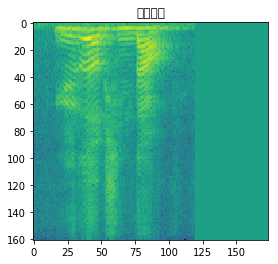

In [25]:
index = 0
#plt.figure(figsize=(30,50))
plt.imshow(a[index,:,:,0])
plt.title(''.join(ind2ch[i] for i in b[index]))
print(''.join(ind2ch[i] for i in b[index]))
print(c[index])
print(d[index])
print(e[index])

In [26]:
import IPython.display as ipd

In [27]:
print(open(d[index],encoding='utf-8').read())
ipd.Audio(c[index])

娱乐频道


In [28]:
def chind2pyind(inputs):
    out = []
    for one in inputs:
        sent = ''.join([ind2ch[i] for i in one])
        outone = ch2py(sent)
        oneoutind = [py2ind.get(i,0) for i in outone]
        out.append(oneoutind)
    return out

In [29]:
''.join([ind2py[i] for i in chind2pyind(b)[0]])

'yú lè pín dào'

# convert data to numpy format

In [30]:
#转化一个序列列表为稀疏矩阵    
def sparse_tuple_from(sequences, dtype=np.int32):
    """
    Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    sequences = chind2pyind(sequences)
    indices = []
    values = []
    
    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)
 
    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)
    
    
    return indices, values, shape

In [31]:
tf.__version__

'1.2.1'

In [32]:
def conv_layer(input_tensor,training,kernel_size=(3,3),filters=32,dropout=None
               ,clip_net=20.,batch_normalization=True,strides=(1,1,1,1),name="conv_layer"):
    with tf.variable_scope(name):
        net = tf.layers.conv2d(input_tensor,filters=filters,kernel_size=kernel_size,padding='same',strides=strides)
        if batch_normalization:
            net = tf.layers.batch_normalization(net,training=training)
        if dropout is not None:
            net = tf.layers.dropout(net,dropout=1.-dropout)
        net = tf.nn.relu(net)
    with tf.variable_scope("minimal"):
        if clip_net is not None and clip_net != False and clip_net > 0:
            net = tf.minimum(net,tf.Variable(clip_net))
    return net

def rnn_layer(input_tensor,layer_num,rnn_seq_lens,rnn_size,training,name="rnn_layer"):
    """
        input should be like [batch_size,time,freq * filters]
    """
    with tf.variable_scope(name):
        net = input_tensor
        for i in range(layer_num):
            with tf.variable_scope("{}_layer{}".format(name,i + 1)):
                forward_cell = tf.contrib.rnn.GRUCell(rnn_size)
                backward_cell = tf.contrib.rnn.GRUCell(rnn_size)
            #bi_outputs, bi_encoder_state,_ = tf.contrib.rnn.static_bidirectional_rnn(
            #        forward_cell,backward_cell,tf.unstack(net,net_shape[1],1),dtype=tf.float32)

                bi_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
                            forward_cell, backward_cell, net,
                            sequence_length = rnn_seq_lens,time_major = False,dtype=tf.float32)
                outputs_fw, outputs_bw = bi_outputs
                rnn_outputs = outputs_fw + outputs_bw
                rnn_outputs = tf.layers.batch_normalization(rnn_outputs, training=training)
                net = rnn_outputs
        return net
    

def _activation_summary(act,tensor_name):
    """Helper to create summaries for activations.
    Creates a summary that provides a histogram of activations.
    Creates a summary that measure the sparsity of activations.
    Args:
      act: Tensor
    """
    # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
    # session. This helps the clarity of presentation on tensorboard.
    tf.summary.histogram(tensor_name + '/activations', act)
    tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(act))
    
def _image_summary(img,tensor_name):
    tf.summary.image(tensor_name,img)

In [33]:
list(range(2,3))

[2]

In [34]:
GPU_CORES

['/gpu:2', '/gpu:3']

In [35]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.


    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)
            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads,0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

In [36]:
list(enumerate(GPU_CORES))

[(0, '/gpu:2'), (1, '/gpu:3')]

In [37]:
assert(len(GPU_CORES) <= 4)
gpu_num = len(GPU_CORES)
tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default():
    initializer = tf.truncated_normal_initializer(
        mean=0.0,stddev=0.02)
    tf.get_variable_scope().set_initializer(initializer)
    
    if gpu_num >= 1:
        input_sound1 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets1 = tf.sparse_placeholder(tf.int32)
    if gpu_num >= 2:
        input_sound2 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets2 = tf.sparse_placeholder(tf.int32)
    if gpu_num >= 3:
        input_sound3 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets3 = tf.sparse_placeholder(tf.int32)
    if gpu_num >= 4:
        input_sound4 = tf.placeholder(tf.float32,shape=[BATCH_SIZE,161,None,1])
        targets4 = tf.sparse_placeholder(tf.int32)
    # [batch_size,freq,time,1]

    voicelength = tf.placeholder(tf.int32, shape=(BATCH_SIZE * gpu_num))
    global_step = tf.train.get_or_create_global_step()
    max_grad = tf.placeholder(tf.float32)
    
    #, shape=np.array([BATCH_SIZE,4], dtype=np.int64))

    learning_rate = tf.placeholder(tf.float32)
    training=tf.placeholder(tf.bool)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    optimizer_sgd = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
    tower_gradients = []
    tower_gradients_sgd = []

with graph.as_default():
    with tf.variable_scope(tf.get_variable_scope()) as vscope:
        for ind,one_core in enumerate(GPU_CORES):
            print(ind)
            with tf.device("".format(one_core)):
                if ind == 0:
                    targets = targets1
                    input_sound = input_sound1
                elif ind == 1:
                    targets = targets2
                    input_sound = input_sound2
                elif ind == 2:
                    targets = targets3
                    input_sound = input_sound3
                elif ind == 3:
                    targets = targets4
                    input_sound = input_sound4

                conv1 = conv_layer(input_sound,training,kernel_size=(41,11),filters=32,strides=(2,2),name="deepspeech_conv_layer1")
                conv2 = conv_layer(conv1,training,kernel_size=(21,11),filters=32,strides=(2,1),name="deepspeech_conv_layer2")
                conv3 = conv_layer(conv2,training,kernel_size=(21,11),filters=96,strides=(2,1),name="deepspeech_conv_layer3")# filters=96 according to paper


                net = conv3
                net = tf.transpose(net,[0,2,1,3])
                net_shape = net.get_shape().as_list()
                net = tf.reshape(net,[BATCH_SIZE,-1,net_shape[-1] * net_shape[-2]])
                # [batch_size,time,freq * filters]
                rnn_out = rnn_layer(net,HIDDEN_LAYERS,voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE],RNN_SIZE,training=training,name="deepspeech_rnn_layer")
                _activation_summary(rnn_out,'rnn_output')
                net_result = tf.layers.dense(rnn_out,len(ind2py) + 2,activation=None,name="deepspeech_dense")
                _activation_summary(net_result,'net_result')

                with tf.variable_scope("Loss"):
                    ctc_loss = tf.nn.ctc_loss(labels=targets,inputs=net_result,sequence_length=voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE]
                                              ,time_major=False)
                    loss = tf.reduce_mean(ctc_loss)
                    tf.summary.scalar("Loss",loss)

                with tf.variable_scope("LearningRate"):
                    tf.summary.scalar("LearningRate",learning_rate)


                decoded, log_prob = tf.nn.ctc_beam_search_decoder(tf.transpose(net_result, (1, 0, 2)),
                                                                  sequence_length=voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE],merge_repeated=False)
                dense_decoded = tf.cast(tf.sparse_tensor_to_dense(decoded[0], default_value=0), tf.int32)

                with tf.variable_scope("EditDistance"):
                    dis = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32), targets))
                    tf.summary.scalar("EditDistance",dis)

                trainable_params = tf.trainable_variables()
                trainable_params = [i for i in trainable_params if
                                    ('deepspeech' in i.name and 'Minimum_grad' not in i.name)]
                #grads_e = optimizer.compute_gradients(ctc_loss, var_list = trainable_params)
                #grads_e_sgd = optimizer_sgd.compute_gradients(ctc_loss, var_list = trainable_params)
                #gradients = tf.gradients(ctc_loss, trainable_params)
                #clip_gradients, _ = tf.clip_by_global_norm(gradients, max_grad)
                #clip_gradients_sgd, _ = tf.clip_by_global_norm(gradients, max_grad)
                #L_loss = tf.clip_by_value(loss, -max_grad, max_grad)
                L_loss = loss
                tf.get_variable_scope().reuse_variables()
                #train_op = optimizer.minimize(loss,global_step=global_step)
                #train_op = optimizer.apply_gradients(
                #        zip(clip_gradients, trainable_params), global_step=global_step)
                grads_e_ori = optimizer.compute_gradients(L_loss, var_list = trainable_params)
                grads_e_ori = [i[0] for i in grads_e_ori]
                grads_e, _ = tf.clip_by_global_norm(grads_e_ori, max_grad)
                #grads_e = grads_e_ori
                grads_e_sgd_ori = optimizer_sgd.compute_gradients(L_loss, var_list = trainable_params)
                grads_e_sgd_ori = [i[0] for i in grads_e_sgd_ori]
                grads_e_sgd, _ = tf.clip_by_global_norm(grads_e_sgd_ori, max_grad)
                #grads_e_sgd = grads_e_sgd_ori
                tower_gradients.append(zip(grads_e,trainable_params))
                tower_gradients_sgd.append(zip(grads_e_sgd,trainable_params))
                print('finish {}'.format(ind))


with graph.as_default():
    summary_op = tf.summary.merge_all()
    train_summary_writer = tf.summary.FileWriter("./log/compair/{}".format(MODEL_NAME), graph)
        
    grads = average_gradients(tower_gradients)
    grads_sgd = average_gradients(tower_gradients_sgd)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.apply_gradients(grads,global_step)
        train_op_sgd = optimizer_sgd.apply_gradients(grads_sgd,global_step)
    with tf.variable_scope("Validation"):
        test_loss = tf.placeholder(tf.float32)
        loss_op = tf.summary.scalar("Accuracy",test_loss)
        editdistance = tf.placeholder(tf.float32)
        editdistance_op = tf.summary.scalar("EditDistance",editdistance)
    test_op = tf.summary.merge([loss_op,editdistance_op])


0
finish 0
1
finish 1


In [38]:
grads_e[:2]

[<tf.Tensor 'clip_by_global_norm_2/clip_by_global_norm_2/_0:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'clip_by_global_norm_2/clip_by_global_norm_2/_1:0' shape=<unknown> dtype=float32>]

In [39]:
grads_e_ori[:2]

[<tf.Tensor 'gradients_2/deepspeech_conv_layer1_1/conv2d/convolution_grad/tuple/control_dependency_1:0' shape=(41, 11, 1, 32) dtype=float32>,
 <tf.Tensor 'gradients_2/deepspeech_conv_layer1_1/conv2d/BiasAdd_grad/tuple/control_dependency_1:0' shape=(32,) dtype=float32>]

In [40]:
net_result.shape,net.shape,ctc_loss.shape,net.shape,net_shape

(TensorShape([Dimension(32), Dimension(None), Dimension(56)]),
 TensorShape([Dimension(32), Dimension(None), Dimension(2016)]),
 TensorShape([Dimension(32)]),
 TensorShape([Dimension(32), Dimension(None), Dimension(2016)]),
 [32, None, 21, 96])

In [41]:
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(REMOTE_WORKER,config=config)
    
    sess.run(tf.global_variables_initializer())
    tf.train.global_step(sess, global_step)

In [42]:
import os
if not os.path.exists("models/{}".format(MODEL_NAME)):
    os.mkdir("models/{}".format(MODEL_NAME))

In [43]:
allmodels = [i  for i in os.listdir('models/{}'.format(MODEL_NAME)) if ('meta' in i and 'model' in i)]

In [44]:
epochs = [int(i[-6]) for i in allmodels]

In [45]:
MODEL_NAME

'1_29-pinyin-opt-aug-chk'

In [46]:
N_BATCH = len(voice_dataset_train) // (BATCH_SIZE * gpu_num)
N_BATCH_TEST = len(voice_dataset_test) // (BATCH_SIZE * gpu_num)

In [47]:
batch_x,batch_y_ori,s,a,t = voice_flow_train.next_batch(BATCH_SIZE)

In [48]:
batch_x.shape

(32, 161, 192, 1)

In [49]:
if epochs:
    train_epoch = max(epochs) + 1
else:
    train_epoch = 1

In [50]:
train_batch = 1

In [51]:
train_epoch

6

In [52]:
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(REMOTE_WORKER,config=config)
    
    saver = tf.train.Saver()
    saver.restore(sess,'./models/{}/model_{}'.format(MODEL_NAME,train_epoch - 1))

INFO:tensorflow:Restoring parameters from ./models/1_29-pinyin-opt-aug-chk/model_5


In [53]:
len(voice_dataset_train)

119338

In [54]:
BATCH_SIZE

32

In [55]:
N_BATCH

1864

In [56]:
e

[120,
 140,
 143,
 135,
 152,
 128,
 138,
 137,
 136,
 139,
 150,
 154,
 160,
 134,
 146,
 155,
 154,
 152,
 140,
 168,
 170,
 163,
 168,
 157,
 154,
 147,
 143,
 161,
 161,
 171,
 162,
 174]

In [ ]:
restore = True
N_EPOCH = 50
DECAY_EPOCH = 6
import traceback

class ExpVal:
    def __init__(self,exp_a=0.97):
        self.val = None
        self.exp_a = exp_a
    def update(self,newval):
        if self.val == None:
            self.val = newval
        else:
            self.val = self.exp_a * self.val + (1 - self.exp_a) * newval
    def getval(self):
        return round(self.val,2)
    
class Tick:
    def __init__(self,tick=True):
        if tick == True:
            self._tick = time.time()
    def tick(self):
        self._tick = time.time()
    def tock(self):
        return round(time.time() - self._tick,2)
        
expdis = ExpVal()
exploss = ExpVal()
clk = Tick()

begining_learning_rate = BEGINING_LEARNING_RATE
clip_norm = 400
with graph.as_default():
    if restore == False:
        train_epoch = 1
        train_batch = 0
    for one_epoch in range(train_epoch,N_EPOCH):
        if one_epoch >= 2:
            voice_flow_train = voice_flow_train_shu
        train_epoch = one_epoch
        pb = ProgressBar(worksum=N_BATCH * BATCH_SIZE * gpu_num,info=" epoch {} batch {}".format(train_epoch,train_batch))
        pb.startjob()

        for one_batch in range(N_BATCH):
            if restore == True and one_batch < train_batch:
                pb.auto_display = False
                pb.complete(BATCH_SIZE)
                pb.auto_display = True
                continue
            else:
                restore = False
            train_batch = one_batch

            clk.tick()
            t1,t2,t3,t4 = [],[],[],[]
            try:
                if gpu_num >= 1:
                    batch_x1,batch_y_ori1,s1,a1,t1 = voice_flow_train.next_batch(BATCH_SIZE)
                    batch_y1 = sparse_tuple_from(batch_y_ori1)
                if gpu_num >= 2:
                    batch_x2,batch_y_ori2,s2,a2,t2 = voice_flow_train.next_batch(BATCH_SIZE)
                    batch_y2 = sparse_tuple_from(batch_y_ori2)
                if gpu_num >= 3:
                    batch_x3,batch_y_ori3,s3,a3,t3 = voice_flow_train.next_batch(BATCH_SIZE)
                    batch_y3 = sparse_tuple_from(batch_y_ori3)
                if gpu_num >= 4:
                    batch_x4,batch_y_ori4,s4,a4,t4 = voice_flow_train.next_batch(BATCH_SIZE)
                    batch_y4 = sparse_tuple_from(batch_y_ori4)
            except:
                continue

            batch_seq_len  = [i // 2 for i in (t1 + t2 + t3 + t4)]
            t1 = clk.tock()

            clk.tick()
            # learning rate decay strategy
            batch_lr = begining_learning_rate * 2 ** -(max(one_epoch-DECAY_EPOCH,0))
            feeddic={
                        

                        learning_rate:batch_lr,voicelength:batch_seq_len,
                        max_grad:clip_norm,training:True
                    }
            if gpu_num >= 1:
                feeddic[input_sound1] = batch_x1
                feeddic[targets1] = batch_y1
            if gpu_num >= 2:
                feeddic[input_sound2] = batch_x2
                feeddic[targets2] = batch_y2
            if gpu_num >= 3:
                feeddic[input_sound3] = batch_x3
                feeddic[targets3] = batch_y3
            if gpu_num >= 4:
                feeddic[input_sound4] = batch_x4
                feeddic[targets4] = batch_y4
            try:
                step_dis,_,step_loss,step_summary,step_value = sess.run(
                    [dis,train_op,loss,summary_op,global_step],feed_dict=feeddic)
            except (KeyboardInterrupt,SystemExit):
                raise
            except:
                traceback.print_exc()
                continue
            expdis.update(step_dis)
            exploss.update(step_loss)
            t2 = clk.tock()
            pb.info = "EPOCH {} STEP {} LR {} LOSS {} DIS {} t1 {} t2 {}".format(one_epoch,one_batch,batch_lr,exploss.getval(),expdis.getval(),t1,t2)
            train_summary_writer.add_summary(step_summary,step_value)
            pb.complete(BATCH_SIZE * gpu_num)
            
        dises,losses = [],[]
        pb = ProgressBar(worksum=N_BATCH_TEST * 2)
        pb.info = "validating EPOCH {}".format(one_epoch)
        pb.startjob()
        for one_batch in range(N_BATCH_TEST * 2):
            t1,t2,t3,t4 = [],[],[],[]
            try:
                if gpu_num >= 1:
                    batch_x1,batch_y_ori1,s1,a1,t1 = voice_flow_test.next_batch(BATCH_SIZE)
                    batch_y1 = sparse_tuple_from(batch_y_ori1)
                if gpu_num >= 2:
                    batch_x2,batch_y_ori2,s2,a2,t2 = voice_flow_test.next_batch(BATCH_SIZE)
                    batch_y2 = sparse_tuple_from(batch_y_ori2)
                if gpu_num >= 3:
                    batch_x3,batch_y_ori3,s3,a3,t3 = voice_flow_test.next_batch(BATCH_SIZE)
                    batch_y3 = sparse_tuple_from(batch_y_ori3)
                if gpu_num >= 4:
                    batch_x4,batch_y_ori4,s4,a4,t4 = voice_flow_test.next_batch(BATCH_SIZE)
                    batch_y4 = sparse_tuple_from(batch_y_ori4)
            except:
                continue
            
            batch_seq_len  = [i // 2 for i in (t1 + t2 + t3 + t4)]

            feeddic={


                        learning_rate:batch_lr,voicelength:batch_seq_len,
                        max_grad:clip_norm,training:False
                    }
            if gpu_num >= 1:
                feeddic[input_sound1] = batch_x1
                feeddic[targets1] = batch_y1
            if gpu_num >= 2:
                feeddic[input_sound2] = batch_x2
                feeddic[targets2] = batch_y2
            if gpu_num >= 3:
                feeddic[input_sound3] = batch_x3
                feeddic[targets3] = batch_y3
            if gpu_num >= 4:
                feeddic[input_sound4] = batch_x4
                feeddic[targets4] = batch_y4
            try:
                step_dis,step_loss,step_value = sess.run(
                    [dis,loss,global_step],feed_dict=feeddic)
            except (KeyboardInterrupt,SystemExit):
                raise
            except:
                traceback.print_exc()
                continue
            dises.append(step_dis)
            losses.append(step_loss)
            pb.complete(1)
        print("\n    EOPCH {} test DIS {} test loss {}".format(one_epoch,np.average(dises),np.average(losses)))
        test_summarys = sess.run(test_op,feed_dict={test_loss:np.average(losses),editdistance:np.average(dises)})
        train_summary_writer.add_summary(test_summarys,step_value)
        print()
        saver = tf.train.Saver(tf.global_variables())
        saver.save(sess,"models/{}/model_{}".format(MODEL_NAME,one_epoch))

EPOCH 6 STEP 49 LR 0.0003 LOSS 9.3 DIS 0.06 t1 2.94 t2 8.41 2.66 % [=>-------------------------------------------------] 3168/119296 	 used:327s eta:12006 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/mul = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/split:1, deepspe

EPOCH 6 STEP 99 LR 0.0003 LOSS 9.69 DIS 0.05 t1 2.96 t2 8.13 5.28 % [==>------------------------------------------------] 6304/119296 	 used:694s eta:12438 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 249 LR 0.0003 LOSS 9.94 DIS 0.05 t1 2.85 t2 8.24 13.28 % [======>--------------------------------------------] 15840/119296 	 used:1720s eta:11236 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 549 LR 0.0003 LOSS 10.54 DIS 0.05 t1 2.21 t2 8.14 29.32 % [==============>------------------------------------] 34976/119296 	 used:3701s eta:8922 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 599 LR 0.0003 LOSS 10.82 DIS 0.05 t1 2.2 t2 8.21 31.95 % [===============>-----------------------------------] 38112/119296 	 used:4062s eta:8653 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer3/bidirectional_rnn/fw/fw/while/Select_grad/zeros_like = ZerosLike[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer3/bidirectional_rnn/fw/fw/whi

EPOCH 6 STEP 649 LR 0.0003 LOSS 10.3 DIS 0.05 t1 2.14 t2 8.36 34.58 % [=================>---------------------------------] 41248/119296 	 used:4464s eta:8447 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,712,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer3/bidirectional_rnn/bw/bw/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer3/bidirectional_rnn/bw/bw/TensorArrayStack/TensorArr

EPOCH 6 STEP 699 LR 0.0003 LOSS 9.98 DIS 0.05 t1 2.74 t2 8.35 37.20 % [==================>--------------------------------] 44384/119296 	 used:4794s eta:8091 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 799 LR 0.0003 LOSS 9.95 DIS 0.05 t1 2.68 t2 8.33 42.52 % [=====================>-----------------------------] 50720/119296 	 used:5453s eta:7372 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 849 LR 0.0003 LOSS 10.43 DIS 0.05 t1 1.93 t2 8.06 45.14 % [======================>----------------------------] 53856/119296 	 used:5798s eta:7045 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/Select_1_grad/zeros_like = ZerosLike[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/w

EPOCH 6 STEP 899 LR 0.0003 LOSS 11.93 DIS 0.06 t1 1.9 t2 8.18 47.77 % [=======================>---------------------------] 56992/119296 	 used:6206s eta:6784 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 949 LR 0.0003 LOSS 10.67 DIS 0.05 t1 2.41 t2 8.16 50.40 % [=========================>-------------------------] 60128/119296 	 used:6540s eta:6435 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,678,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/ReverseSequence = ReverseSequence[T=DT_FLOAT, Tlen=DT_INT32, batch_dim=0, seq_dim=1, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/batch_normalizatio

EPOCH 6 STEP 999 LR 0.0003 LOSS 10.19 DIS 0.05 t1 2.05 t2 8.28 53.03 % [==========================>------------------------] 63264/119296 	 used:6858s eta:6073 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/split = Split[T=DT_FLOAT, num_split=2, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell

EPOCH 6 STEP 1099 LR 0.0003 LOSS 10.26 DIS 0.05 t1 1.63 t2 8.02 58.34 % [=============================>---------------------] 69600/119296 	 used:7497s eta:5353 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/mul_1 = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/sub, deepspeech_rnn_

EPOCH 6 STEP 1149 LR 0.0003 LOSS 10.9 DIS 0.05 t1 2.03 t2 8.39 60.97 % [==============================>--------------------] 72736/119296 	 used:7827s eta:5010 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/

EPOCH 6 STEP 1199 LR 0.0003 LOSS 10.43 DIS 0.05 t1 2.31 t2 8.16 63.60 % [===============================>-------------------] 75872/119296 	 used:8142s eta:4659 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 6 STEP 1249 LR 0.0003 LOSS 10.29 DIS 0.05 t1 1.63 t2 8.24 66.23 % [=================================>-----------------] 79008/119296 	 used:8454s eta:4310 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 1299 LR 0.0003 LOSS 10.69 DIS 0.05 t1 1.73 t2 8.46 68.86 % [==================================>----------------] 82144/119296 	 used:8790s eta:3975 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirect

EPOCH 6 STEP 1399 LR 0.0003 LOSS 11.0 DIS 0.06 t1 2.54 t2 8.26 74.17 % [=====================================>-------------] 88480/119296 	 used:9412s eta:3278 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,482,400]
	 [[Node: zero_fraction/Cast = Cast[DstT=DT_FLOAT, SrcT=DT_BOOL, _device="/job:local/replica:0/task:0/gpu:0"](zero_fraction/Equal)]]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/stack_G18881 = _Recv[client_terminated=false, recv_device="/job

EPOCH 6 STEP 1449 LR 0.0003 LOSS 10.36 DIS 0.05 t1 1.61 t2 8.11 76.80 % [======================================>------------] 91616/119296 	 used:9727s eta:2938 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/split = Split[T=DT_FLOAT, num_split=2, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell

EPOCH 6 STEP 1499 LR 0.0003 LOSS 10.41 DIS 0.05 t1 1.55 t2 8.22 79.43 % [=======================================>-----------] 94752/119296 	 used:10046s eta:2602 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,611,400]
	 [[Node: gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_normalization/moments/shifted_mean_grad/Tile = Tile[T=DT_FLOAT, Tmultiples=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_nor

EPOCH 6 STEP 1599 LR 0.0003 LOSS 10.59 DIS 0.05 t1 1.62 t2 8.15 84.74 % [==========================================>--------] 101088/119296 	 used:10647s eta:1917 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.InternalError: Dst tensor is not initialized.
	 [[Node: Loss/CTCLoss_G18725 = _Recv[client_terminated=false, recv_device="/job:local/replica:0/task:0/gpu:0", send_device="/job:local/replica:0/task:0/cpu:0", send_device_incarnation=-2859741753184269959, tensor_name="edge_2937_Loss/CTCLoss", tensor_type=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0

EPOCH 6 STEP 1799 LR 0.0003 LOSS 10.71 DIS 0.05 t1 1.35 t2 8.13 95.41 % [===============================================>---] 113824/119296 	 used:11823s eta:568 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 6 STEP 1849 LR 0.0003 LOSS 10.84 DIS 0.05 t1 1.32 t2 8.31 98.04 % [=================================================>-] 116960/119296 	 used:12136s eta:242 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

validating EPOCH 6 100.00 % [==================================================>] 446/446 	 used:1078s eta:0 s
    EOPCH 6 test DIS 0.05750013887882233 test loss 11.072160720825195

EPOCH 7 STEP 0 LR 0.00015 LOSS 10.39 DIS 0.05 t1 1.11 t2 7.09 0.05 % [>--------------------------------------------------] 64/119296 	 used:8s eta:14989 sshuffle
validating EPOCH 7 100.00 % [==================================================>] 446/446 	 used:1086s eta:0 s
    EOPCH 7 test DIS 0.04905952513217926 test loss 9.675293922424316

EPOCH 8 STEP 1 LR 7.5e-05 LOSS 7.53 DIS 0.04 t1 1.25 t2 7.72 0.11 % [>--------------------------------------------------] 128/119296 	 used:17s eta:15721 sshuffle
EPOCH 8 STEP 50 LR 7.5e-05 LOSS 7.16 DIS 0.04 t1 1.41 t2 8.15 2.74 % [=>-------------------------------------------------] 3264/119296 	 used:291s eta:10368 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/split = Split[T=DT_FLOAT, num_split=2, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell

EPOCH 8 STEP 100 LR 7.5e-05 LOSS 6.68 DIS 0.03 t1 1.31 t2 7.87 5.36 % [==>------------------------------------------------] 6400/119296 	 used:598s eta:10561 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[459,32,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 = TensorArrayGatherV3[dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:local/replica:0/task:0/gpu:

EPOCH 8 STEP 250 LR 7.5e-05 LOSS 6.4 DIS 0.03 t1 1.3 t2 7.88 13.36 % [======>--------------------------------------------] 15936/119296 	 used:1477s eta:9582 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_laye

EPOCH 8 STEP 350 LR 7.5e-05 LOSS 6.28 DIS 0.03 t1 1.39 t2 8.18 18.67 % [=========>-----------------------------------------] 22272/119296 	 used:2070s eta:9021 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,667,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/TensorArrayStack/TensorArr

EPOCH 8 STEP 400 LR 7.5e-05 LOSS 6.39 DIS 0.03 t1 1.35 t2 8.22 21.30 % [==========>----------------------------------------] 25408/119296 	 used:2378s eta:8787 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 500 LR 7.5e-05 LOSS 6.39 DIS 0.03 t1 1.3 t2 8.27 26.61 % [=============>-------------------------------------] 31744/119296 	 used:2971s eta:8194 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirect

EPOCH 8 STEP 600 LR 7.5e-05 LOSS 6.57 DIS 0.03 t1 1.29 t2 8.18 31.92 % [===============>-----------------------------------] 38080/119296 	 used:3581s eta:7639 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 8 STEP 650 LR 7.5e-05 LOSS 6.07 DIS 0.03 t1 1.27 t2 8.23 34.55 % [=================>---------------------------------] 41216/119296 	 used:3893s eta:7375 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/candidate/candidate/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_laye

EPOCH 8 STEP 750 LR 7.5e-05 LOSS 6.48 DIS 0.03 t1 1.46 t2 8.14 39.86 % [===================>-------------------------------] 47552/119296 	 used:4483s eta:6763 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 900 LR 7.5e-05 LOSS 6.34 DIS 0.03 t1 1.24 t2 8.25 47.85 % [=======================>---------------------------] 57088/119296 	 used:5369s eta:5851 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/mul = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/split,

EPOCH 8 STEP 950 LR 7.5e-05 LOSS 6.5 DIS 0.03 t1 1.29 t2 8.27 50.48 % [=========================>-------------------------] 60224/119296 	 used:5663s eta:5555 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,609,400]
	 [[Node: gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_normalization/moments/shifted_mean_grad/Tile = Tile[T=DT_FLOAT, Tmultiples=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_nor

EPOCH 8 STEP 1000 LR 7.5e-05 LOSS 6.63 DIS 0.03 t1 1.25 t2 8.15 53.11 % [==========================>------------------------] 63360/119296 	 used:5970s eta:5271 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,575,400]
	 [[Node: gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_normalization/moments/shifted_mean_grad/Tile = Tile[T=DT_FLOAT, Tmultiples=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_nor

EPOCH 8 STEP 1050 LR 7.5e-05 LOSS 6.43 DIS 0.03 t1 1.26 t2 8.16 55.74 % [===========================>-----------------------] 66496/119296 	 used:6275s eta:4982 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 1200 LR 7.5e-05 LOSS 6.31 DIS 0.03 t1 1.33 t2 8.28 63.73 % [===============================>-------------------] 76032/119296 	 used:7162s eta:4075 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.InternalError: Dst tensor is not initialized.
	 [[Node: CTCBeamSearchDecoder_G18735 = _Recv[client_terminated=false, recv_device="/job:local/replica:0/task:0/gpu:0", send_device="/job:local/replica:0/task:0/cpu:0", send_device_incarnation=-2859741753184269959, tensor_name="edge_2953_CTCBeamSearchDecoder", tensor_type=DT_INT64, _device="/job:local/replic

EPOCH 8 STEP 1300 LR 7.5e-05 LOSS 6.41 DIS 0.03 t1 1.33 t2 8.44 69.05 % [==================================>----------------] 82368/119296 	 used:7762s eta:3480 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 1400 LR 7.5e-05 LOSS 6.19 DIS 0.03 t1 1.37 t2 8.3 74.36 % [=====================================>-------------] 88704/119296 	 used:8358s eta:2882 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 8 STEP 1450 LR 7.5e-05 LOSS 6.03 DIS 0.03 t1 1.3 t2 8.11 76.98 % [======================================>------------] 91840/119296 	 used:8667s eta:2591 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/mul = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/split:1, deepspe

EPOCH 8 STEP 1550 LR 7.5e-05 LOSS 6.21 DIS 0.03 t1 1.36 t2 8.37 82.30 % [=========================================>---------] 98176/119296 	 used:9268s eta:1993 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,479,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/batch_normalization/moments/shifted_mean_grad/Tile = Tile[T=DT_FLOAT, Tmultiples=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/batch_normalizati

EPOCH 8 STEP 1650 LR 7.5e-05 LOSS 6.11 DIS 0.03 t1 1.34 t2 7.99 87.61 % [===========================================>-------] 104512/119296 	 used:9855s eta:1393 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=true, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepspeec

EPOCH 8 STEP 1700 LR 7.5e-05 LOSS 6.29 DIS 0.03 t1 1.31 t2 8.2 90.24 % [=============================================>-----] 107648/119296 	 used:10164s eta:1099 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 8 STEP 1750 LR 7.5e-05 LOSS 6.05 DIS 0.03 t1 1.31 t2 8.08 92.86 % [==============================================>----] 110784/119296 	 used:10469s eta:804 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/split = Split[T=DT_FLOAT, num_split=2, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/bw/bw/while/bw/gru_cell

EPOCH 8 STEP 1850 LR 7.5e-05 LOSS 6.2 DIS 0.03 t1 1.24 t2 8.25 98.18 % [=================================================>-] 117120/119296 	 used:11065s eta:205 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,625,400]
	 [[Node: gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_normalization/moments/shifted_mean_grad/Tile = Tile[T=DT_FLOAT, Tmultiples=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/batch_nor

validating EPOCH 8 100.00 % [==================================================>] 446/446 	 used:1099s eta:0 s
    EOPCH 8 test DIS 0.03989650681614876 test loss 8.209115982055664

EPOCH 9 STEP 1 LR 3.75e-05 LOSS 6.02 DIS 0.03 t1 1.36 t2 7.34 0.11 % [>--------------------------------------------------] 128/119296 	 used:16s eta:14921 sshuffle
validating EPOCH 9 100.00 % [==================================================>] 446/446 	 used:1057s eta:0 s
    EOPCH 9 test DIS 0.0379130057990551 test loss 7.8813157081604

EPOCH 10 STEP 2 LR 1.875e-05 LOSS 5.39 DIS 0.03 t1 1.19 t2 8.35 0.16 % [>--------------------------------------------------] 192/119296 	 used:24s eta:14965 sshuffle
EPOCH 10 STEP 101 LR 1.875e-05 LOSS 5.24 DIS 0.03 t1 1.19 t2 8.12 5.47 % [==>------------------------------------------------] 6528/119296 	 used:578s eta:9994 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 201 LR 1.875e-05 LOSS 5.24 DIS 0.03 t1 1.35 t2 8.39 10.78 % [=====>---------------------------------------------] 12864/119296 	 used:1183s eta:9787 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[463,32,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 = TensorArrayGatherV3[dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:local/replica:0/task:0/gpu:

EPOCH 10 STEP 251 LR 1.875e-05 LOSS 4.93 DIS 0.02 t1 1.32 t2 8.05 13.41 % [======>--------------------------------------------] 16000/119296 	 used:1490s eta:9623 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirect

EPOCH 10 STEP 351 LR 1.875e-05 LOSS 5.0 DIS 0.03 t1 1.22 t2 8.41 18.72 % [=========>-----------------------------------------] 22336/119296 	 used:2093s eta:9088 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer3/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/mul = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer3/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/split,

EPOCH 10 STEP 401 LR 1.875e-05 LOSS 4.96 DIS 0.03 t1 1.2 t2 8.2 21.35 % [==========>----------------------------------------] 25472/119296 	 used:2401s eta:8844 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 551 LR 1.875e-05 LOSS 5.09 DIS 0.02 t1 1.3 t2 8.35 29.35 % [==============>------------------------------------] 35008/119296 	 used:3276s eta:7888 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirect

EPOCH 10 STEP 601 LR 1.875e-05 LOSS 5.1 DIS 0.03 t1 1.29 t2 8.07 31.97 % [===============>-----------------------------------] 38144/119296 	 used:3585s eta:7628 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[455,32,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 = TensorArrayGatherV3[dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:local/replica:0/task:0/gpu:

EPOCH 10 STEP 651 LR 1.875e-05 LOSS 4.8 DIS 0.02 t1 1.38 t2 8.25 34.60 % [=================>---------------------------------] 41280/119296 	 used:3891s eta:7355 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 701 LR 1.875e-05 LOSS 4.92 DIS 0.02 t1 1.37 t2 8.07 37.23 % [==================>--------------------------------] 44416/119296 	 used:4200s eta:7082 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_laye

EPOCH 10 STEP 801 LR 1.875e-05 LOSS 4.74 DIS 0.02 t1 1.34 t2 8.1 42.54 % [=====================>-----------------------------] 50752/119296 	 used:4793s eta:6473 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/

EPOCH 10 STEP 851 LR 1.875e-05 LOSS 5.01 DIS 0.03 t1 1.34 t2 7.92 45.17 % [======================>----------------------------] 53888/119296 	 used:5102s eta:6193 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 951 LR 1.875e-05 LOSS 4.93 DIS 0.02 t1 1.26 t2 8.14 50.48 % [=========================>-------------------------] 60224/119296 	 used:5709s eta:5599 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/

EPOCH 10 STEP 1001 LR 1.875e-05 LOSS 5.11 DIS 0.03 t1 1.31 t2 8.15 53.11 % [==========================>------------------------] 63360/119296 	 used:6017s eta:5312 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/mul = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/split,

EPOCH 10 STEP 1051 LR 1.875e-05 LOSS 4.83 DIS 0.02 t1 1.15 t2 8.03 55.74 % [===========================>-----------------------] 66496/119296 	 used:6336s eta:5031 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/candidate/candidate/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_laye

EPOCH 10 STEP 1151 LR 1.875e-05 LOSS 5.03 DIS 0.02 t1 1.22 t2 8.54 61.05 % [==============================>--------------------] 72832/119296 	 used:6942s eta:4428 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,631,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer4/bidirectional_rnn/fw/fw/TensorArrayStack/TensorArr

EPOCH 10 STEP 1251 LR 1.875e-05 LOSS 4.99 DIS 0.02 t1 1.23 t2 8.14 66.36 % [=================================>-----------------] 79168/119296 	 used:7536s eta:3819 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,800]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/

EPOCH 10 STEP 1351 LR 1.875e-05 LOSS 4.83 DIS 0.02 t1 1.27 t2 8.05 71.67 % [===================================>---------------] 85504/119296 	 used:8123s eta:3210 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/split = Split[T=DT_FLOAT, num_split=2, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell

EPOCH 10 STEP 1401 LR 1.875e-05 LOSS 5.08 DIS 0.03 t1 1.17 t2 8.71 74.30 % [=====================================>-------------] 88640/119296 	 used:8446s eta:2921 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/while/bw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 10 STEP 1751 LR 1.875e-05 LOSS 5.15 DIS 0.03 t1 1.33 t2 8.09 93.03 % [==============================================>----] 110976/119296 	 used:10465s eta:784 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/mul_1 = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/sub, deepspeech_rnn_

validating EPOCH 10 100.00 % [==================================================>] 446/446 	 used:1079s eta:0 s
    EOPCH 10 test DIS 0.036840979009866714 test loss 7.733739852905273

EPOCH 11 STEP 2 LR 9.375e-06 LOSS 5.22 DIS 0.03 t1 1.14 t2 7.01 0.16 % [>--------------------------------------------------] 192/119296 	 used:22s eta:13829 sshuffle
validating EPOCH 11 100.00 % [==================================================>] 446/446 	 used:1084s eta:0 s
    EOPCH 11 test DIS 0.03637055680155754 test loss 7.678442478179932

EPOCH 12 STEP 3 LR 4.6875e-06 LOSS 4.73 DIS 0.02 t1 1.14 t2 7.91 0.21 % [>--------------------------------------------------] 256/119296 	 used:30s eta:14251 sshuffle
EPOCH 12 STEP 52 LR 4.6875e-06 LOSS 4.55 DIS 0.02 t1 1.26 t2 8.16 2.84 % [=>-------------------------------------------------] 3392/119296 	 used:303s eta:10371 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,470,400]
	 [[Node: zero_fraction/Cast = Cast[DstT=DT_FLOAT, SrcT=DT_BOOL, _device="/job:local/replica:0/task:0/gpu:0"](zero_fraction/Equal)]]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/bw/bw/stack_G18881 = _Recv[client_terminated=false, recv_device="/job

EPOCH 12 STEP 202 LR 4.6875e-06 LOSS 4.85 DIS 0.02 t1 1.29 t2 7.98 10.84 % [=====>---------------------------------------------] 12928/119296 	 used:1178s eta:9692 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,400]
	 [[Node: deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/mul_1 = Mul[T=DT_FLOAT, _device="/job:local/replica:0/task:0/gpu:0"](deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/sub, deepspeech_rnn_

EPOCH 12 STEP 252 LR 4.6875e-06 LOSS 4.74 DIS 0.02 t1 1.23 t2 8.0 13.47 % [======>--------------------------------------------] 16064/119296 	 used:1500s eta:9644 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[800,800]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/fw/while/fw/gru_cell/gates/gates/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepsp

EPOCH 12 STEP 302 LR 4.6875e-06 LOSS 4.74 DIS 0.02 t1 1.24 t2 7.84 16.09 % [========>------------------------------------------] 19200/119296 	 used:1823s eta:9503 s

Traceback (most recent call last):
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1139, in _do_call
    return fn(*args)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1121, in _run_fn
    status, run_metadata)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/data/zonghua/envs/icybee/lib/python3.5/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))
tensorflow.python.framework.errors_impl.ResourceExhaustedError: OOM when allocating tensor with shape[32,443,400]
	 [[Node: gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/transpose_grad/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:local/replica:0/task:0/gpu:0"](gradients/deepspeech_rnn_layer/deepspeech_rnn_layer_layer5/bidirectional_rnn/fw/f

EPOCH 12 STEP 344 LR 4.6875e-06 LOSS 4.64 DIS 0.02 t1 0.96 t2 5.95 18.29 % [=========>-----------------------------------------] 21824/119296 	 used:2052s eta:9164 s

In [ ]:
batch_xx,batch_y_ori1,s1,a1,t1 = voice_flow_train.next(1)['data']

In [ ]:
batch_xx.shape,BATCH_SIZE

In [ ]:
start = time.time()
step_dis,step_loss,step_value = sess.run(
                    [dis,loss,global_step],feed_dict=feeddic)
print(time.time() - start)

In [ ]:
DECAY_EPOCH = 10
begining_learning_rate = BEGINING_LEARNING_RATE
for one_epoch in range(1,30):
    print(begining_learning_rate * 2 ** -(max(one_epoch-DECAY_EPOCH,0)))

In [ ]:
1